# Global Root-zone moisture Analysis & Forecasting System (GRAFS) <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:**
[GRAFS](http://dap.nci.org.au/thredds/remoteCatalogService?catalog=http://dapds00.nci.org.au/thredds/catalog/ub8/global/GRAFS/catalog.xml)

## Background

Soil moisture is a measure of water stored in soil that is accessible to plant roots, therefore a major contributing factor to plant health and crop yield.

The Global Root-zone moisture Analysis & Forecasting System (GRAFS) is produced by the [ANU Centre for Water and Landscape Dynamics](www.wald.anu.edu.au).
The model estimates the surface (0-5 cm) and root-zone (0-1 m) soil moisture at 10 km spatial resolution globally, using the precipitation measured by the Global Precipitation Measurement (GPM) mission and through assimilation of soil moisture product from the Soil Moisture Active/Passive (SMAP) mission.

This product is regularly updated and made available through National Computational Infrastructure's open access THREDDS data server.

For more information on this product, contact [Luigi Renzullo](mailto:Luigi.Renzullo@anu.edu.au) and [Siyuan Tian](mailto:siyuan.tian@anu.edu.au).

## Description

This notebook demonstrates the following steps:
1. Retrieval of surface and root-zone wetness through NCI's THREDDS OPeNDAP service
2. Compare soil moisture to precipitation data from ERA5

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import datacube

import sys
sys.path.append("../Scripts")
from deafrica_load_era5 import load_era5

### Analysis parameters

In [2]:
# Define the analysis region (Lat-Lon box)

# Il Ngwesi region of Kenya - Rhino Project
lat = (0.412, 0.266)
lon = (37.32, 37.40)

# High Energy Stereoscopic System site near Windhoek Namibia
#lat = (-23.28, -23.26)
#lon = (16.49, 16.51)

# Define the time window
time = '2018-07-01', '2019-05-31'

## Retrieval of surface and root-zone wetness

> Wetness is measured relative to wettest condition recorded for a location.

In [3]:
# function to load soil moisture data

def load_soil_moisture(lat, lon, time, product = 'surface', nrt = False):
    product_baseurl = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/'
    assert product in ['surface', 'rootzone'], 'product parameter must be surface or root-zone'
    # lat, lon grid
    lat_range = np.arange(np.max(np.ceil(np.array(lat)*10.+0.5)/10.-0.05), np.min(np.floor(np.array(lat)*10.-0.5)/10.+0.05)-0.05, -0.1)
    lon_range = np.arange(np.min(np.floor(np.array(lon)*10.-0.5)/10.+0.05), np.max(np.ceil(np.array(lon)*10.+0.5)/10.-0.05)+0.05, 0.1)
    # split time window into years
    day_range = np.array(time).astype("M8[D]")
    year_range = np.array(time).astype("M8[Y]")
    if product == 'surface':
        product_name = 'Surface_Wetness_from_API_'
    else: product_name = 'SWI_1m_'
    if nrt:
        product_name += 'forecast'
    else: product_name += 'analysis'
    datasets = []
    for year in np.arange(year_range[0], year_range[1]+1, np.timedelta64(1, 'Y')):
        start = np.max([day_range[0], year.astype("M8[D]")])
        end = np.min([day_range[1], (year+1).astype("M8[D]")-1])
        product_url = product_baseurl + product_name +'_window_%s.nc'%str(year)
        print(product_url)
        # data is loaded lazily through OPeNDAP
        ds = xr.open_dataset(product_url)
        # slice before return
        ds = ds.sel(lat=lat_range, lon=lon_range, time=slice(start, end)).compute()
        datasets.append(ds)
    return xr.merge(datasets)

In [4]:
# retrieve surface soil moisture using query parameters
surface_wetness = load_soil_moisture(lat, lon, time)

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/Surface_Wetness_from_API_analysis_window_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/Surface_Wetness_from_API_analysis_window_2019.nc


In [5]:
# retrieve rootzone soil moisture using query parameters
rootzone_wetness = load_soil_moisture(lat, lon, time, product='rootzone')

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/SWI_1m_analysis_window_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/SWI_1m_analysis_window_2019.nc


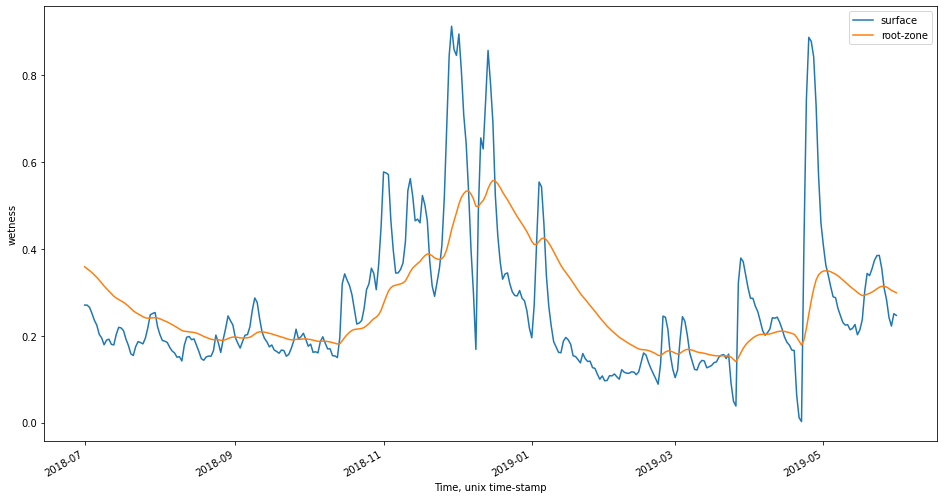

In [6]:
# plot surface and root-zone wetness over time
surface_wetness.wetness.groupby('time').mean(...).plot(figsize=(16,8), label='surface');
rootzone_wetness.wetness.groupby('time').mean(...).plot(label='root-zone');
plt.legend();

## Compare soil moisture to precipitation data from ERA5

In [7]:
# load precipitation data from ERA5
var_precipitation = 'precipitation_amount_1hour_Accumulation'
precipitation = load_era5(var_precipitation, lat, lon, time, reduce_func=np.sum)

# Convert from Meters (m) to Millimeters (mm)
precipitation[var_precipitation]=precipitation[var_precipitation]*1000

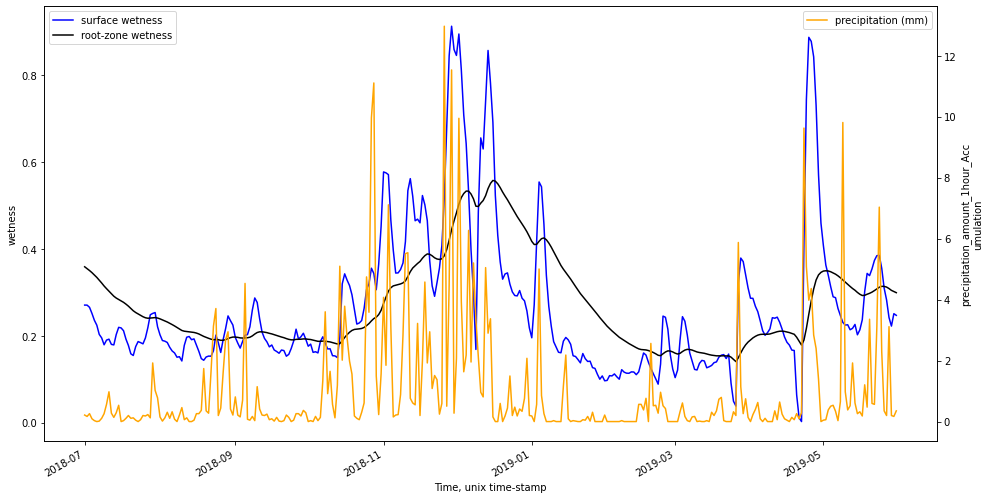

In [8]:
# plot soil moisture with precipitation

fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
surface_wetness.wetness.groupby('time').mean(...).plot(ax = ax1, label = 'surface wetness', color = 'blue');
rootzone_wetness.wetness.groupby('time').mean(...).plot(ax = ax1, label = 'root-zone wetness', color = 'black');
precipitation[var_precipitation].groupby('time').mean(...).plot(ax = ax2, label = 'precipitation (mm)', color = 'orange');
ax1.legend();
ax2.legend();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)

**Tags**:  :index:`soil moisture`, :index:`precipitation`